# [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)

### Phillip Isola, Jun-Yan Zhu, Tinghui Zhou & Alexei A. Efros

Algorithm for image-to-image translation. Below are some applications and results:

<img src="images/pix2pix-teaser.png">

## Set Up the pix2pix Model

In [1]:
%pylab inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

device_txt = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_txt)
# Print Device Type
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

### Define by User ###
# Choose dataset, available ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps"]
use_dataset = 'cityscapes'
direction='BtoA'
######################
# Define Training Details
epochs     = 200
batch_size = 10
# Learning Rate (Adam) and beta1 (beta2=0.999 always)
lr    = 0.0002
beta1 = 0.5

import urllib.request

# Download dataset
url = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/'+use_dataset+'.tar.gz'
urllib.request.urlretrieve(url, './data.tar.gz')

Populating the interactive namespace from numpy and matplotlib


('./data.tar.gz', <http.client.HTTPMessage at 0x7f24b1b1e860>)

### Extract data and download saved models

In [2]:
!mkdir data saved_models
# Extract data
!tar -xzf data.tar.gz -C data/ && rm data.tar.gz
# Download saved weights
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jZZhu_ivjzgS1nE-aAUZOUxLrGYNjjaX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jZZhu_ivjzgS1nE-aAUZOUxLrGYNjjaX" -O saved_models/pix2pix.tar && rm -rf /tmp/cookies.txt
!tar xf saved_models/pix2pix.tar -C saved_models/ && rm saved_models/pix2pix.tar

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘saved_models’: File exists
--2020-06-15 17:48:27--  https://docs.google.com/uc?export=download&confirm=uHkx&id=1jZZhu_ivjzgS1nE-aAUZOUxLrGYNjjaX
Resolving docs.google.com (docs.google.com)... 2a00:1450:4001:820::200e, 216.58.205.238
Connecting to docs.google.com (docs.google.com)|2a00:1450:4001:820::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-8o-docs.googleusercontent.com/docs/securesc/c2977rnpp120g6g5dm882pu79aq6mk6a/0fnm5mgfjp9ji0qe2m4p1pn358fbrg8i/1592236050000/08634931705470539405/05953293231548136967Z/1jZZhu_ivjzgS1nE-aAUZOUxLrGYNjjaX?e=download [following]
--2020-06-15 17:48:27--  https://doc-0c-8o-docs.googleusercontent.com/docs/securesc/c2977rnpp120g6g5dm882pu79aq6mk6a/0fnm5mgfjp9ji0qe2m4p1pn358fbrg8i/1592236050000/08634931705470539405/05953293231548136967Z/1jZZhu_ivjzgS1nE-aAUZOUxLrGYNjjaX?e=download
Resolving doc-0c-8o-docs.goog

### Generator Network

In [3]:
class G_unet(nn.Module):
    def __init__(self, in_nc, out_nc, ngf, bz):
        super(G_unet, self).__init__()
        self.bz = bz
        ## ENCODER ##
        # 1st encoder layer input: batch_size x 3 x 256 x 256 (for in_nc = 3)
        self.e1    = nn.Conv2d(in_nc, ngf, kernel_size=4, stride=2, padding=1)
        # 2nd encoder layer input: batch_size x 64 x 128 x 128 (for ngf = 64)
        self.e2    = nn.Conv2d(ngf, ngf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*2)
        # 3rd encoder layer input: batch_size x 128 x 64 x 64 (for ngf = 64)
        self.e3    = nn.Conv2d(ngf*2, ngf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*4)
        # 4th encoder layer input: batch_size x 256 x 32 x 32 (for ngf = 64)
        self.e4    = nn.Conv2d(ngf*4, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf*8)
        # 5th to 8th endocer layer input: batch_size x 512 x 16 x 16 (for ngf = 64)
        self.e5  = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf*8)
        # 6th endocer layer input: batch_size x 512 x 8 x 8 (for ngf = 64)
        self.e6  = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf*8)
        # 7th endocer layer input: batch_size x 512 x 4 x 4 (for ngf = 64)
        self.e7  = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(ngf*8)
        # 8th endocer layer input: batch_size x 512 x 2 x 2 (for ngf = 64)
        self.e8  = nn.Conv2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        if bz>1:
          self.bn8 = nn.BatchNorm2d(ngf*8)
        ## DECODER ##
        # 1st decoder layer input: batch_size x 512 x 1 x 1 (for ngf = 64)
        self.d1    = nn.ConvTranspose2d(ngf*8, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(ngf*8)
        # 2nd decoder layer input: batch_size x 512 x 2 x 2 (for ngf = 64)
        self.d2  = nn.ConvTranspose2d(ngf*8*2, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(ngf*8)
        # 3rd decoder layer input: batch_size x 512 x 4 x 4 (for ngf = 64)
        self.d3  = nn.ConvTranspose2d(ngf*8*2, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf*8)
        # 4th decoder layer input: batch_size x 512 x 8 x 8 (for ngf = 64)
        self.d4  = nn.ConvTranspose2d(ngf*8*2, ngf*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn12 = nn.BatchNorm2d(ngf*8)
        # 3rd to 5th decoder layer input: batch_size x 512 x 4->8->16 x 4->8->16 (for ngf = 64)
        self.d5    = nn.ConvTranspose2d(ngf*8*2, ngf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn13 = nn.BatchNorm2d(ngf*4)
        # 6th decoder layer input: batch_size x 512 x 32 x 32 (for ngf = 64)
        self.d6    = nn.ConvTranspose2d(ngf*4*2, ngf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn14 = nn.BatchNorm2d(ngf*2)
        # 7th decoder layer input: batch_size x 512 x 64 x 64 (for ngf = 64)
        self.d7    = nn.ConvTranspose2d(ngf*2*2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn15 = nn.BatchNorm2d(ngf)
        # 7th decoder layer input: batch_size x 512 x 128 x 128 (for ngf = 64)
        self.d8    = nn.ConvTranspose2d(ngf*2, out_nc, kernel_size=4, stride=2, padding=1)
        # Output size: batch_size x 3 x 256 x 256 (for out_nc = 3)
        
    def forward(self, input):
        # 1st encoder-layer
        u_e1 = F.leaky_relu(self.e1(input), negative_slope=0.2, inplace=True)
        # 2nd encoder-layer
        u_e2 = F.leaky_relu(self.bn2(self.e2(u_e1)), negative_slope=0.2, inplace=True)
        # 3rd encoder-layer
        u_e3 = F.leaky_relu(self.bn3(self.e3(u_e2)), negative_slope=0.2, inplace=True)
        # 4th encoder-Layer
        u_e4 = F.leaky_relu(self.bn4(self.e4(u_e3)), negative_slope=0.2, inplace=True)
        # 5th encoder-layer
        u_e5 = F.leaky_relu(self.bn5(self.e5(u_e4)), negative_slope=0.2, inplace=True)
        # 6th encoder-layer
        u_e6 = F.leaky_relu(self.bn6(self.e6(u_e5)), negative_slope=0.2, inplace=True)
        # 7th encoder-layer
        u_e7 = F.leaky_relu(self.bn7(self.e7(u_e6)), negative_slope=0.2, inplace=True)
        # Bottleneck
        if self.bz>1:
          u_e8 = F.relu(self.bn7(self.e8(u_e7)), inplace=True)
        else:
          u_e8 = F.relu(self.e8(u_e7), inplace=True)
        # 1st decoder layer
        u_d1 = F.dropout2d(self.bn9(self.d1(u_e8)), p=0.5)
        u_d1 = F.relu(torch.cat([u_d1, u_e7], dim=1), inplace=True)
        # 2nd decoder layer
        u_d2 = F.dropout2d(self.bn10(self.d2(u_d1)), p=0.5)
        u_d2 = F.relu(torch.cat([u_d2, u_e6], dim=1), inplace=True)
        # 3rd decoder layer
        u_d3 = F.dropout2d(self.bn11(self.d3(u_d2)), p=0.5)
        u_d3 = F.relu(torch.cat([u_d3, u_e5], dim=1), inplace=True)
        # 4th decoder layer
        u_d4 = F.relu(torch.cat([self.bn12(self.d4(u_d3)), u_e4], dim=1), inplace=True)
        # 5th decoder layer
        u_d5 = F.relu(torch.cat([self.bn13(self.d5(u_d4)), u_e3], dim=1), inplace=True)
        # 6th decoder layer
        u_d6 = F.relu(torch.cat([self.bn14(self.d6(u_d5)), u_e2], dim=1), inplace=True)
        # 7th decoder layer
        u_d7 = F.relu(torch.cat([self.bn15(self.d7(u_d6)), u_e1], dim=1), inplace=True)
        # Final layer
        return torch.tanh(self.d8(u_d7))

### Discriminator Network

In [4]:
from collections import OrderedDict

class D_basic_layer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=4, stride=2, padding=1):
        super(D_basic_layer, self).__init__()
        self.conv  = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn    = nn.BatchNorm2d(out_ch)
    
    def forward(self, input):
        return F.leaky_relu(self.bn(self.conv(input)), negative_slope=0.2, inplace=True)

class D_basic(nn.Module):
    def __init__(self, in_nc, out_nc, ndf, n_layer=3):
        super(D_basic, self).__init__()
        # Define PixelGAN if n_layers=0
        if n_layer==0:
            self.conv1 = nn.Conv2d(in_nc+out_nc, ndf, kernel_size=1, stride=1, padding=0)
            self.main  = nn.Sequential(OrderedDict([
                ("basic1", D_basic_layer(ndf, ndf*2, kernel_size=1, stride=1, padding=0))
            ]))
            self.final = nn.Conv2d(ndf*2, 1, kernel_size=1, stride=1, padding=0)
        # Else 16x16 (n_layer=1), 34x34 (n_layer=2), 70x70 (n_layer=3), 142x142 (n_layer=4), 286x286 (n_layer=5)
        else:
            self.conv1 = nn.Conv2d(in_nc+out_nc, ndf, kernel_size=4, stride=2, padding=1)
            self.main  = nn.Sequential(OrderedDict(
                [("basic" + str(i+1), D_basic_layer(ndf*2**i, ndf*2**(i+1)) if i<3
                     else D_basic_layer(ndf*8, ndf*8)) for i in range(n_layer-1)] +
                [("basic" + str(n_layer), D_basic_layer(ndf*min(2**(n_layer-1),8), ndf*min(2**(n_layer),8), stride=1))
            ]))
            self.final = nn.Conv2d(ndf*min(2**(n_layer),8), 1, kernel_size=4, stride=1, padding=1)
    
    def forward(self, input, label):
        input = torch.cat([input, label], dim=1)
        input = F.leaky_relu(self.conv1(input), negative_slope=0.2, inplace=True)
        input = self.main(input)
        return torch.sigmoid(self.final(input))
  

#### Weights Initialization

In [5]:
# custom weights initialization
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)

#### Compact function to get optimizer and model

In [6]:
import os

def get_pix2pix(in_nc, out_nc, ngf, ndf, device, batch_size, lr = 0.0002, beta1 = 0.5):
    model_G = G_unet(in_nc, out_nc, ngf, batch_size).to(device)
    model_D = D_basic(in_nc, out_nc, ndf).to(device)
    # Init weights
    [m.apply(weights_init) for m in (model_G, model_D)]
    # Set starting epoch to 0 as default
    epoch_start    = 0
        
    # Check for pretrained Model
    if os.path.isfile('./saved_models/pix2pix_'+use_dataset+direction+'_saved_model.tar'):
        pretrained = "Users_answer"
        while pretrained not in ["y","n"]:
            pretrained = input("Pretrained Model available, use it? [y/n]:")
        # If User says "y", load weights
        if pretrained=="y":
            # Load data
            saved_data = torch.load('./saved_models/pix2pix_'+use_dataset+direction+'_saved_model.tar', map_location=device)
            # Transmit data
            model_G.load_state_dict(saved_data['G_state_dict'])
            model_D.load_state_dict(saved_data['D_state_dict'])
            epoch_start    = saved_data['current_epoch']
            
    # Define Adam optimizer
    opt_G = optim.Adam(model_G.parameters(), lr=lr, betas=(beta1,0.999))
    opt_D = optim.Adam(model_D.parameters(), lr=lr, betas=(beta1,0.999))
    
    return model_G, model_D, opt_G, opt_D, epoch_start

## Load Data

In [7]:
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
import random


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', direction='AtoB', resize=None, crop_size=None,
                 h_flip=None, v_flip=None, rotate_angle=None, jitter=None, transform=None):
        """
        Args:
            image_dir (str): Path to folders for train, val amd test
            subfolder (str): Folder with images
            direction (str) : Either 'AtoB' or 'BtoA' indicating which direction the prediction should go
            resize (int or tuple): If int image will be resized to square otherwise to tuple size
            crop_size (int) : Square random crop
            v_flip (bool) : Perform random vertical flip with p=0.5
            h_flip (bool) : Perform random horizontal flip with p=0.5
            rotate_degree (int): Random rotate degree between (-value,value)
            jitter (bool) : For randomly change brightness, contrast, saturation and hue
            transform (torchvision obj) : Other transformation that have no randomization in it
        """
        super(DatasetFromFolder, self).__init__()
        self.input_path      = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.direction       = direction
        self.resize          = resize
        self.crop_size       = crop_size
        self.h_flip          = h_flip
        self.v_flip          = v_flip
        self.rotate_angle    = rotate_angle
        self.jitter          = jitter
        self.transform       = transform

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn)
        if self.direction == 'AtoB':
            input  = img.crop((0, 0, img.width // 2, img.height))
            target = img.crop((img.width // 2, 0, img.width, img.height))
        elif self.direction == 'BtoA':
            input  = img.crop((img.width // 2, 0, img.width, img.height))
            target = img.crop((0, 0, img.width // 2, img.height))

        # preprocessing
        if self.resize:
            if isinstance(self.resize, int):
                input  = input.resize((self.resize, self.resize), Image.BILINEAR)
                target = target.resize((self.resize, self.resize), Image.BILINEAR)
            else:
                input  = input.resize(self.resize[::-1], Image.BILINEAR)
                target = target.resize(self.resize[::-1], Image.BILINEAR)
        
        if self.h_flip:
            if random.random() < 0.5:
                input  = input.transpose(Image.FLIP_LEFT_RIGHT)
                target = target.transpose(Image.FLIP_LEFT_RIGHT)
        
        if self.v_flip:
            if random.random() < 0.5:
                input  = input.transpose(Image.FLIP_TOP_BOTTOM)
                target = target.transpose(Image.FLIP_TOP_BOTTOM)
                
        if self.rotate_angle:
            rnd_angle = random.randint(-self.rotate_angle, self.rotate_angle)
            input  = input.rotate(rnd_angle, expand=True)
            target = target.rotate(rnd_angle, expand=True)
        
        if self.jitter:
            target = transforms.functional.adjust_brightness(input, random.uniform(0.5,1.5))
            target = transforms.functional.adjust_contrast(input, random.uniform(0.75,1.25))
            target = transforms.functional.adjust_saturation(input, random.uniform(0.5,1.5))
            target = transforms.functional.adjust_hue(input, random.uniform(-0.05,0.05))
        
        if self.crop_size:
            # Get Random initial x and y coordinate
            x = random.randint(0, self.resize - self.crop_size + 1)
            
            y = random.randint(0, self.resize - self.crop_size + 1)
            # Crop
            input  = input.crop((x, y, x + self.crop_size, y + self.crop_size))
            target = target.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.transform is not None:
            input  = self.transform(input)
            target = self.transform(target)
        
        return input, target

    def __len__(self):
        return len(self.image_filenames)

In [8]:
# Data pre-processing
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Train data
train_ds = DatasetFromFolder('./data/'+use_dataset+'/', subfolder='train', resize=286, crop_size=256, 
                             direction=direction, h_flip=True, transform=transform)

train_dl = data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

## Train Model

In [9]:
def fit_pix2pix(epochs, model_G, model_D, opt_G, opt_D, train_dl, device, lamb = 100,
                epoch_start=0, show_iter=None):
    
    # Check if start_epoch is greater than number of epochs, stop if the case
    if epoch_start>epochs:
        return
    
    # Define Losses
    BCE_Loss = nn.BCELoss()
    L1_loss  = nn.L1Loss()
    
    # Take time
    start_time = time.time()
    
    # If not otherwise defined: show_iter = one epoch
    if show_iter is None:
      show_iter=len(train_dl)

    for epoch in range(epoch_start, epochs):
        # Start Training Loop
        for i, (input, label) in enumerate(train_dl):
            # push images to device
            x,y = input.to(device), label.to(device)
        
            ### Discriminator Training ###
            model_D.zero_grad()
            # Real pictures
            out_real = model_D(x,y).squeeze()
            lossD_real = BCE_Loss(out_real, torch.ones(out_real.size(), device=device))
        
            # Fake pictures 
            out_fake_D = model_D(x, model_G(x).detach()).squeeze()
            # Loss function with all zeros for being fake
            lossD_fake = BCE_Loss(out_fake_D, torch.zeros(out_fake_D.size(), device=device))
            
            lossD = (lossD_real + lossD_fake)/2
            lossD.backward()
            opt_D.step()
            
            ### Generator Training ###
            model_G.zero_grad()
            gen_img = model_G(x)
            out_fake_G = model_D(x, gen_img).squeeze()
            # BCE Loss with all ones for simplitic training (see DCGAN)
            BCE_lossG = BCE_Loss(out_fake_G, torch.ones(out_fake_G.size(), device=device))
            # L1_loss
            L1_lossG  = L1_loss(gen_img, y)
            # Combine with user specified lambda
            lossG = BCE_lossG + lamb*L1_lossG
            lossG.backward()
            opt_G.step()
            
            # Show some Optimazation metrics
            if (i+epoch*len(train_dl))%show_iter == 0:
                # get time values
                hours, rem = divmod(time.time()-start_time, 3600)
                minutes, seconds = divmod(rem, 60)
                print('({:0>2}:{:0>2}:{:0>2}) [{}/{}][{}/{}] -> {:.2f}%\tLoss_D: {:.4f}, D(x): {:.4f}\tLoss_G: {:.4f}, D(G(z)): {:.4f}'.format(
                    int(hours),int(minutes), int(seconds), epoch, epochs, i, len(train_dl),
                    100*(i+epoch*len(train_dl))/(epochs*len(train_dl)), lossD, out_real.mean(),
                    lossG, out_fake_D.mean()))
              
            # Show currently inputs and Generated
            if (i+epoch*len(train_dl))%(5*show_iter) == 0:
                inputs  = x.cpu()
                targets = y.cpu()
                fakes   = model_G(x).detach().cpu()
                img_tmp = torch.cat([inputs, targets, fakes], dim=3)
                plt.figure(figsize=(15,5))
                plt.axis("off")
                plt.imshow(np.transpose(vutils.make_grid(img_tmp[:4], nrow=2, padding=2, normalize=True),(1,2,0)))
                plt.pause(0.001)
                
        ###############
        # save current state, epoch and saved losses
        torch.save({'G_state_dict': model_G.state_dict(),
                    'D_state_dict': model_D.state_dict(),
                    'current_epoch': epoch+1,
                   },'./saved_models/pix2pix_'+use_dataset+direction+'_saved_model.tar')

In [10]:
# Get initialized models and optimizers
model_G, model_D, opt_G, opt_D, epoch_start = get_pix2pix(in_nc=3, out_nc=3,
                                                          ngf=64, ndf=64,
                                                          device=device,
                                                          batch_size=batch_size,
                                                          lr=lr, beta1=beta1)
# Fit pix2pix
fit_pix2pix(epochs, model_G, model_D, opt_G, opt_D, train_dl, device, 100, epoch_start)

Pretrained Model available, use it? [y/n]:y


### Test model

In [13]:
# Get Test set
test_ds = DatasetFromFolder('./data/'+use_dataset+'/', subfolder='val', resize=286, crop_size=256, 
                             direction=direction, h_flip=True, transform=transform)

test_dl = data.DataLoader(dataset=test_ds, batch_size=4, shuffle=True)

X_test, Y_test = next(iter(test_dl))

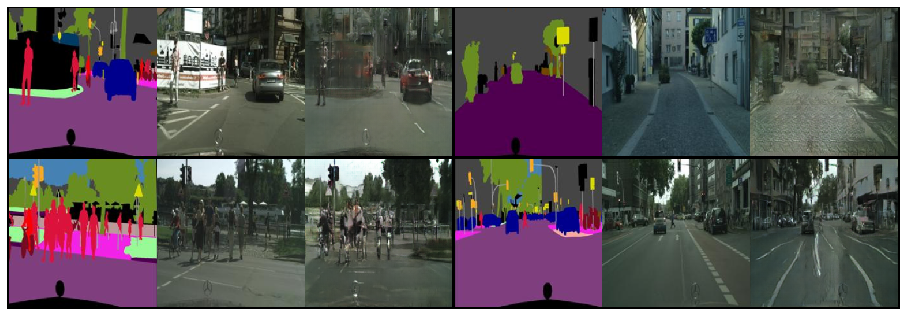

In [14]:
# Plot some training images
fakes_test = model_G(X_test.to(device)).detach().cpu()
img_tmp = torch.cat([X_test, Y_test, fakes_test], dim=3)
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(img_tmp, nrow=2, padding=4, normalize=True),(1,2,0)))
plt.pause(0.001)